In [1]:
from matplotlib.pyplot import subplots, tight_layout, figure

from numpy import loadtxt, reshape, mean, corrcoef, cumsum

import nibabel as nib

import matplotlib.animation as animation


# Overview

- Concept of decomposition

- Preprocessing

- Principal Components

- Explained variance and principal components


# What is dimensionality reduction?

- High dimensional datasets are characterised by large number of measured features
- Typical examples are neuroimaging (eg. fMRI and EEG), transcriptomics studies, mutation/risk factor studies


- This can be a problem for data exploration, visualisation, storage and machine learning applications


- Dimensionality reduction methods generally do two things for optimal "data compression":
  - reduce the number of columns (features).   Each feature is a "combination" of the original measured features
  - retain maximal variance/separability // minimize information loss

<img src="goal.png">

# Load and Visualise fMRI Data 

We will use some fMRI BOLD imaging data when human subjects were viewing different visual stimuli. For more on BOLD imaging, see [here](https://www.sciencedirect.com/science/article/pii/B9780123864567076103)

The original dataset is from: http://www.pymvpa.org/datadb/haxby2001.html

In [3]:
fmri_raw = nib.load("bold.nii")

In [4]:
# Convert to numpy array

img1 = fmri_raw.get_fdata()

img1.shape


(40, 64, 64, 1452)

In [5]:
# This is a 4D dataset - a signal timeseries of a 3D volume
# Different from a structural MRI

[nX, nY, nSlices, nTimepoints] = img1.shape

print( 'nX = ', nX, ', nY = ', nY, ', Slices = ', nSlices, ', nFrames = ', nTimepoints)

nX =  40 , nY =  64 , Slices =  64 , nFrames =  1452


In [6]:
my_slice = 40

data_series = img1[:,:,my_slice,:]

data_series.shape  


(40, 64, 1452)

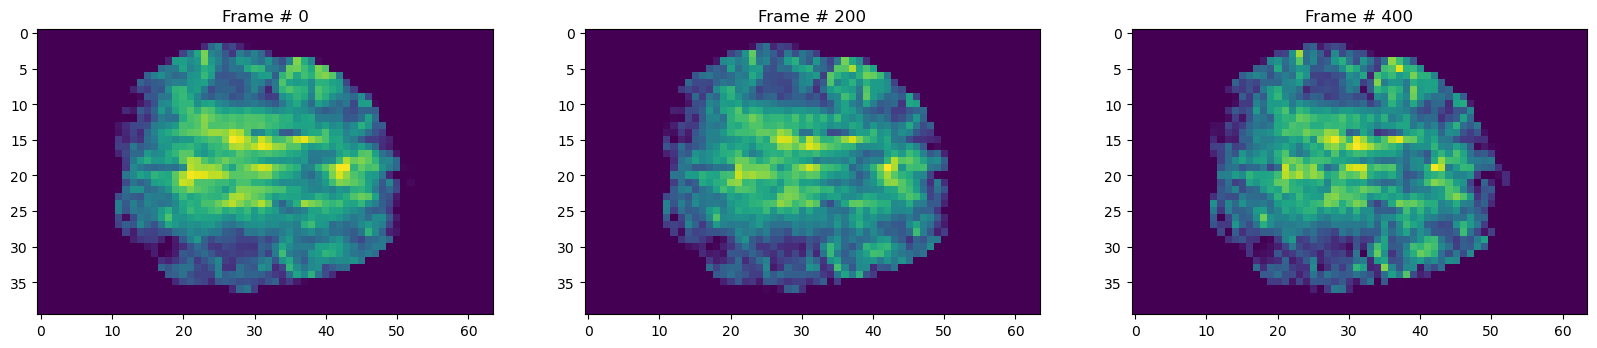

In [7]:
# Plot different timeframes of the same slice

frames = 3

fig, ax = subplots(ncols=frames, figsize=(20, 4))

for ctr in range(frames):

    frame = ctr*200
    
    im = ax[ctr].imshow(data_series[:,:, frame], vmin=1600)

    ax[ctr].set_title('Frame # '+ str(frame) )


# Video

'repeat=True'

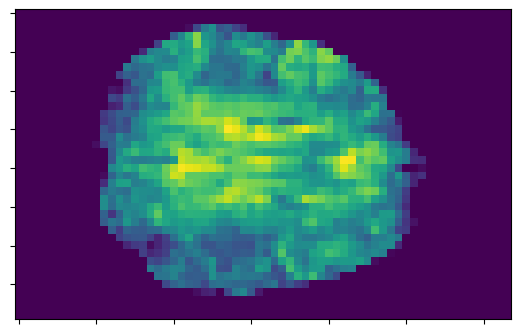

In [9]:
fig, ax = subplots()

def animate(numb):
    
    ax.clear()

    ax.imshow(data_series[:,:, 5*numb], vmin=1500)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

resolution = 5

frames = int(data_series.shape[2] / resolution)

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100)

, repeat=True

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html

# anim.save('test_BOLD.mp4', fps=20, extra_args=['-vcodec', 'libx264'])


## Preprocessing

- Mask image
- Combine all slices and pixels as features
- Normlise data

Note: You can also skip the steps below to directly load preprocessed data:

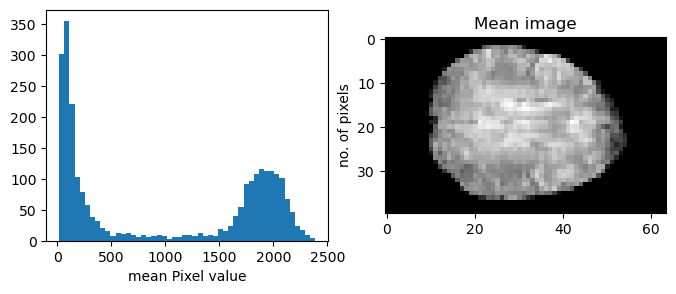

In [10]:
# mean image across all timepoints

mean_image =  mean(data_series, 2 )

fig, ax = subplots(nrows=1, ncols=2, figsize=(8,3))
ax[0].hist(mean_image.flatten(), bins=50);
ax[0].set_xlabel('mean Pixel value');
ax[1].set_ylabel('no. of pixels');

ax[1].imshow(mean_image, cmap="gray", vmin=1000);
ax[1].set_title('Mean image');


### Reshape data into pixels versus timepoints

We need to mask the image - subselect the pixels we want to analyse. As we want the same pixels on each frame to get the pixel timeseries, we should apply the same mask on each timepoint.

Before we mask the image, we will collapse the xy into a single column. This will make it to apply the same mask to each timepoint.

### Reshape data into pixels versus timepoints

We need to mask the image - subselect the pixels we want to analyse. As we want the same pixels on each frame to get the pixel timeseries, we should apply the same mask on each timepoint.

Before we mask the image, we will collapse the xy into a single column. This will make it to apply the same mask to each timepoint.

In [11]:
# Collapse x-y-t pixels into a 2D array of pixel-t

data_series_flat = reshape(data_series, (nX*nY, nTimepoints))
data_series_flat.shape


(2560, 1452)

In [12]:
# Collapse xy pixels into  a single array of pixels

mean_image_flat = reshape(mean_image, nX*nY, order='F')
mean_image_flat.shape


(2560,)

### Remove dark background

In [13]:
# Find mask 
threshold = 1000 
mask      = mean_image_flat > 1000

# apply mask and crop data for all timepoints (second dimension)
data_masked = data_series_flat[mask,:]

data_masked.shape

(1244, 1452)

### Reshape data to timepoints versus pixels

Finally, as most sklearn functions expect data to be _samples_ x _features_ format, we will transpose the data which is currently in the opposite format.

In [14]:
data_final = data_masked.transpose()

print('Time points = ', nTimepoints, ', Pixels = ', data_final.shape[1])

# Note that the number of features is less than the total number of pixels (as we have removed dark pixels)

Time points =  1452 , Pixels =  1244


# Load Pre-processed Data

In [17]:
data_preprocessed = loadtxt('data_preprocessed.csv',delimiter=",")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data = scaler.fit_transform(data_preprocessed)

data.shape


(1452, 1244)

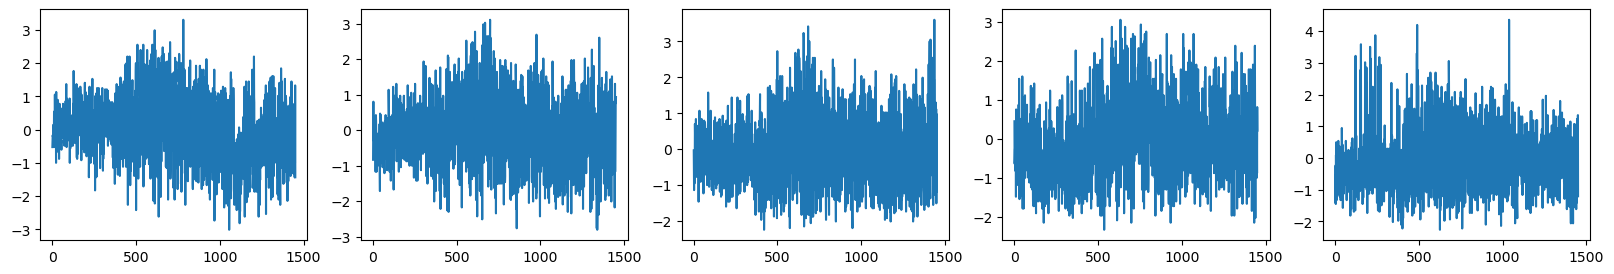

In [18]:
# Time series of the data

pixels = 5

fig, ax = subplots(ncols=pixels, figsize=(20, 3))


for pixel in range(pixels):
    
    ax[pixel].plot(data[:,pixel])


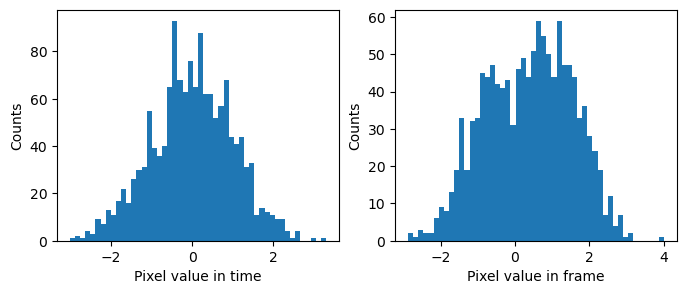

In [19]:
fig, ax = subplots(ncols=2, figsize=(8, 3))

ax[0].hist(data[:, 0].flatten(), bins=50);
ax[0].set_xlabel('Pixel value in time');
ax[0].set_ylabel('Counts');

ax[1].hist(data[0, :].flatten(), bins=50);
ax[1].set_xlabel('Pixel value in frame');
ax[1].set_ylabel('Counts');

Typically, there are many other pre-processing steps, including correcting for brain movement, removing outlier frames, transforming data using some kernels ("functional PCA") - but for this tutorial, we will work with this preprocessing.

# PCA

Principal component analysis is a very commonly used dimensionality reduction method - for data exploration and visualisation, as well as for preprocessing data for machine learning applications.

Retaining lots of pixels with correlated variability can be a problem for fitting supervised learning models - esp when number of samples << number of features.

Instead, PCA transforms the data into a _feature space_ which allows an adequate description of the data with a fewer number of features.

## State Space plots

In a state space plot, we use the activity of each pixel as a different axis. Thus each row is a point in this state space. 

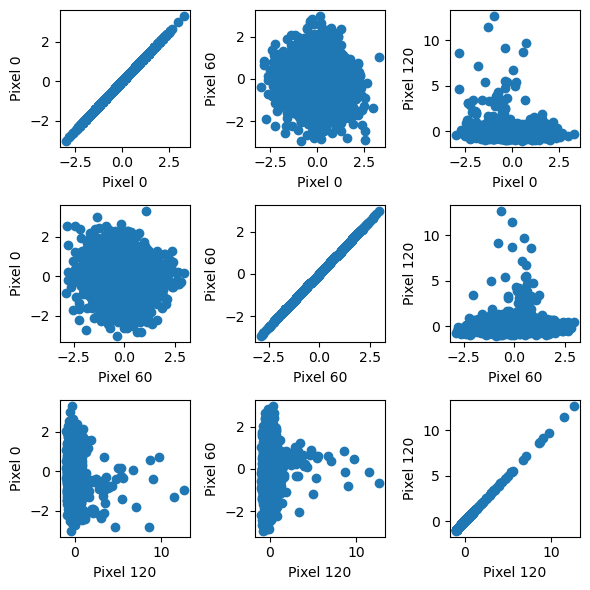

In [20]:
# Plotting for the first 3 pixels:

fig, ax = subplots(nrows=3, ncols=3, figsize=(6, 6))

for pixel1 in range(3):
    
    for pixel2 in range(3):
        
        pick = 60
        
        ax[pixel1,pixel2].scatter(data[:,pixel1*pick], data[:,pixel2*pick])
        ax[pixel1,pixel2].set_xlabel('Pixel ' + str(pixel1*pick))
        ax[pixel1,pixel2].set_ylabel('Pixel ' + str(pixel2*pick))

fig.tight_layout()

The activity along pixels co-varies to some extent

## Correlation matrix

Pixels against pixels

Time points: 1452 Pixels: 1244



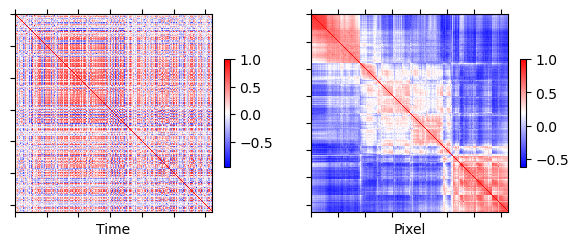

In [21]:
fig, ax = subplots(ncols=2, figsize=(7, 7))

im1 = ax[0].matshow(corrcoef(data, rowvar=False), cmap="bwr")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlabel('Time')

fig.colorbar(im1, ax=ax[0], shrink=0.2, ticks=(-0.5, 0, 0.5, 1));

im2 = ax[1].matshow(corrcoef(data.T, rowvar=False), cmap="bwr")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xlabel('Pixel')

fig.colorbar(im2, ax=ax[1], shrink=0.2, ticks=(-0.5, 0, 0.5, 1));


print('Time points:', data.shape[0], 'Pixels:', data.shape[1])
print('')

In [22]:
1244**2

1547536

## Apply PCA

Goal:  Convert from   [Tx N]   to   [Tx K], where k<<N

### X-Y Sketch

In [23]:
from sklearn.decomposition import PCA


In [24]:
nComp = 200

pca = PCA(n_components=nComp)

pca.fit(data_final)


PCA(n_components=200)

## Variance captured

In [25]:
# variance by each component (normalised)
exp_var = pca.explained_variance_ratio_

# total variance explained
cumu_exp_var = cumsum(exp_var) / sum(exp_var)


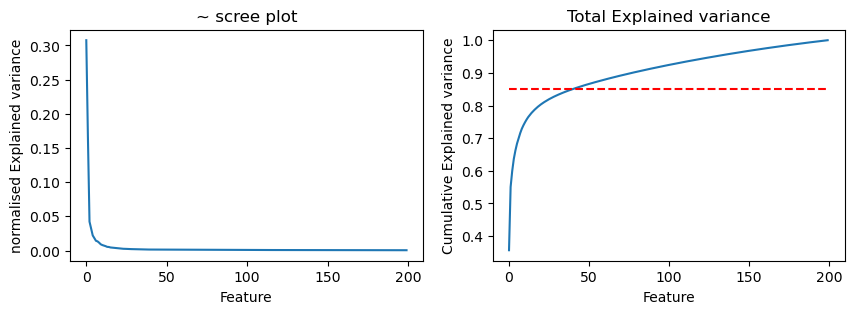

In [26]:
fig, ax = subplots(ncols=2, figsize=(10,3))

ax[0].plot(exp_var)
ax[0].set_xlabel('Feature'); 
ax[0].set_ylabel('normalised Explained variance');
ax[0].set_title('~ scree plot');

ax[1].plot(cumu_exp_var)
ax[1].set_xlabel('Feature'); 
ax[1].set_ylabel('Cumulative Explained variance');
ax[1].set_title('Total Explained variance');

threshold = 0.85

ax[1].hlines(threshold, 0, len(cumu_exp_var), 'r', linestyles='dashed');
# ax[1].margins(x=0)


There are two common heuristics for selecting number of components:
- Find the 'elbow' in the [scree plot](https://methods.sagepub.com/reference/the-sage-encyclopedia-of-educational-research-measurement-and-evaluation/i18507.xml#:~:text=A%20scree%20plot%20is%20a,analysis%20or%20a%20factor%20analysis.) (where successive components have dramatically lower contributions)
- Keep a minimum number of features such that cumulative explained variance is 80-90% (or any pre-determined threshold)

## Selecting number of features

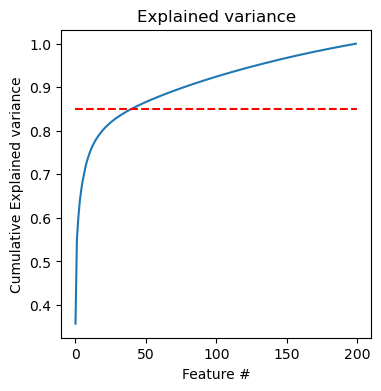

In [27]:
threshold = 0.85

fig,ax = subplots(figsize=(4,4))

ax.plot(cumu_exp_var)
ax.plot([0,nComp],[threshold,threshold],'r--')

ax.set_xlabel('Feature #'); 
ax.set_ylabel('Cumulative Explained variance');
ax.set_title('Explained variance');


## Fit and transform

Let's fit and transform the data into this smaller feature space, determined by _minPC_

In [28]:
pca2 = PCA(n_components=50)

data_reduced = pca2.fit_transform(data_final)


In [29]:
data_final.shape, data_reduced.shape

((1452, 1244), (1452, 50))

## Visualise data in PC space

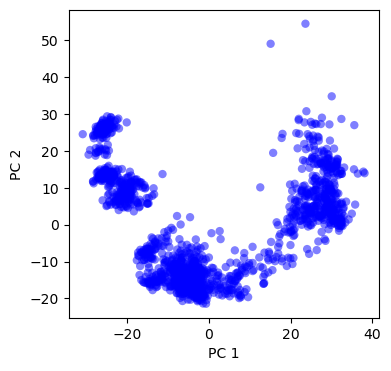

In [39]:
## Looking at new projected data along the first two features

fig,ax = subplots(figsize=(4,4))

ax.scatter(data_reduced[:, 0], data_reduced[:, 1], edgecolor='none', alpha=0.5, c='b')
ax.set_xlabel('PC 1');
ax.set_ylabel('PC 2');


These axes are now the principal components.

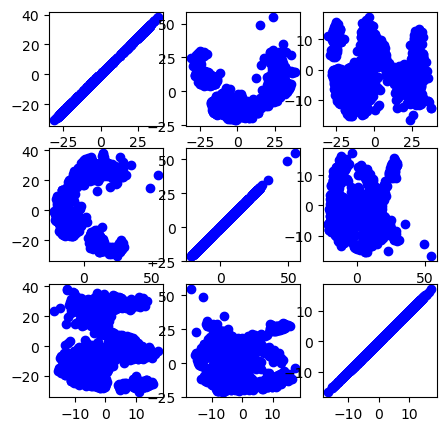

In [36]:
## Plot a few more

comps = 3

fig, ax = subplots(nrows=comps, ncols=comps, figsize=(5, 5))

for comp1 in range(comps):
    
    for comp2 in range(comps):
        
        ax[comp1, comp2].scatter(data_reduced[:,comp1], data_reduced[:,comp2], c='b')
        